### Jack's car rental problem

In [271]:
import numpy as np
import random
import scipy
import tqdm
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

In [80]:
def poissons(Lambda):
    n=np.arange(21)
    factorial=np.ones(21)
    for i in range(1,21):
        factorial[i]=factorial[i-1]*(i)
    return np.power(Lambda,n)*np.exp(-Lambda)/factorial
    

In [94]:
def p_req_resp():
    """
        Calculates the probability of request, response combinations at location A and B
    """
    request_A=poissons(3)
    request_B=poissons(4)
    return_A=poissons(3)
    return_B=poissons(2)
    p=np.matmul(np.expand_dims(request_A,-1),np.expand_dims(request_B,0)).reshape((-1,1))
    p=np.matmul(p,np.expand_dims(return_A,0)).reshape((-1,1))
    return np.matmul(p,np.expand_dims(return_B,0)).reshape((21,21,21,21))

In [149]:
def p_sdash_r_s_a():
    """
        Return p{dict}: (s,a)-->{(s_,r)-->p}
    
    """
    p=dict()
    P_req_resp=p_req_resp()
    for i in tqdm.tqdm(range(21)):
        for j in range(21):
            for action in range(-5, 6):
                p[((i,j),action)]=dict()
                for req_a in range(21):
                    for req_b in range(21):
                        for ret_a in range(21):
                            for ret_b in range(21):
                                if i-action>=0 and i-action<=20 and j+action>=0 and j+action<=20:
                                    i_=min(i-action,20)
                                    j_=min(j+action,20)
                                    reward=10*min(req_a,i_)+10*min(req_b,j_)-2*abs(action)
                                    i_=min(max(i_-req_a,0)+ret_a,20)
                                    j_=min(max(j_-req_b,0)+ret_b,20)
                                    p[((i,j),action)][((i_,j_),reward)]=p[((i,j),action)].get(((i_,j_),reward),0) + \
                                                                        P_req_resp[req_a,req_b,ret_a,ret_b]
    return p

#### Calculate the four argument dynamics function

In [150]:
P_sdash_r_s_a=p_sdash_r_s_a()

100%|██████████| 21/21 [19:26<00:00, 55.53s/it] 


In [152]:
with open('P_sdash_r_s_a.bin','wb') as f:
    pickle.dump(P_sdash_r_s_a,f,protocol=pickle.HIGHEST_PROTOCOL)

In [153]:
def policy_evaluation(v_s,pi,gamma,theta=0.01):
    while True:
        v_s_back=v_s.copy()
        for i in range(21):
            for j in range(21):
                pi_s=pi[i,j]
                v_s[i,j]=0
                for key,p in P_sdash_r_s_a[((i,j),pi_s)].items():
                    (i_,j_),r=key
                    v_s[i,j]+=p*(r+gamma*v_s[i_,j_])
        print(abs(v_s-v_s_back).max())
        if abs(v_s-v_s_back).max()<theta: break

In [154]:
def policy_improvement(v_s,pi,gamma=0.9):
    for i in range(21):
        for j in range(21):
            best_a=pi[i,j]
            best_q_s_a=0
            for a in range(-5,6):
                q_s_a=0
                for key,p in P_sdash_r_s_a[((i,j),a)].items():
                    (i_,j_),r=key
                    q_s_a+=p*(r+gamma*v_s[i_,j_])
                if best_q_s_a<q_s_a:
                    best_q_s_a=q_s_a
                    best_a=a
            pi[i,j]=best_a

In [156]:
v_s=np.zeros((21,21))
pi=np.zeros((21,21),dtype=int)
print(pi)
for _ in range(0,10):
    policy_evaluation(v_s,pi,gamma=0.9)
    policy_improvement(v_s,pi,gamma=0.9)
    print(pi)

[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
198.5619350354157
131.1757770000379
80.62956305823721


32.6293444581346
15.246270170760795
6.3578389745536015
3.4612582128186204
2.0797695945192345
1.2692132485982484
0.7946113251537099
0.5146298958985653
0.3752260629340185
0.29425070540764864
0.22685427832703908
0.17414885550073222
0.13524250912104208
0.10605037747711776
0.08301441136609355
0.06490539731004219
0.050706313227919964
0.039592351564067485
0.030903350398148177
0.02411551091478259
0.018815619135125417
0.01467894112806789
0.011450921898983779
0.008932353392367531
[[ 0  0  0  0  0  0  0  0  0 -1 -1 -2 -2 -2 -2 -2 -3 -3 -3 -3 -3]
 [ 0  0  0  0  0  0  0  0  0  0 -1 -1 -1 -1 -1 -2 -2 -2 -2 -2 -2]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1 -1 -1 -1 -1 -1 -2]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1 -1]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1]
 [ 1  1  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 2  2  1  1  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 3  2  2  2  1  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  

41.72245683087266
11.167847571587572
2.9853891481945993
1.5064182588655513
0.9106024891307243
0.6044934042906789
0.4719958367219874
0.3724760763611812
0.2862327662969619
0.21906438706133713
0.1710421632311636
0.1339574112904529
0.10485965568670963
0.08205597529371289
0.06419821359662592
0.050220200418038985
0.03928229443084774
0.0307249399909324
0.024030862157985666
0.018794777426364817
0.014699348683450353
0.011496202348553197
0.00899099280138671
[[ 0  0  0  0  0  0  0  0 -1 -1 -2 -2 -2 -3 -3 -3 -3 -3 -3 -3 -4]
 [ 0  0  0  0  0  0  0  0  0 -1 -1 -1 -2 -2 -2 -2 -2 -2 -2 -3 -3]
 [ 0  0  0  0  0  0  0  0  0  0  0 -1 -1 -1 -1 -1 -1 -1 -2 -2 -2]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1 -1 -1 -2]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1 -1]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1]
 [ 1  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1]
 [ 2  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1]
 [ 2  1  1  0  0  0 

### Exercise 4.7

In [160]:
def p_sdash_r_s_a_ex47():
    """
        Return p{dict}: (s,a)-->{(s_,r)-->p}
    
    """
    p=dict()
    P_req_resp=p_req_resp()
    for i in tqdm.tqdm(range(21)):
        for j in range(21):
            for action in range(-5, 6):
                p[((i,j),action)]=dict()
                for req_a in range(21):
                    for req_b in range(21):
                        for ret_a in range(21):
                            for ret_b in range(21):
                                if i-action>=0 and i-action<=20 and j+action>=0 and j+action<=20:
                                    i_=min(i-action,20)
                                    j_=min(j+action,20)
                                    action_val=action
                                    if abs(action_val)!=0: action_val=abs(action_val)-1
                                    reward=10*min(req_a,i_)+10*min(req_b,j_)-2*abs(action_val)
                                    #More than 4 cars after moving
                                    if i_>10:
                                        reward-=4
                                    if j_>20:
                                        reward-=4
                                    i_=min(max(i_-req_a,0)+ret_a,20)
                                    j_=min(max(j_-req_b,0)+ret_b,20)
                                    p[((i,j),action)][((i_,j_),reward)]=p[((i,j),action)].get(((i_,j_),reward),0) + \
                                                                        P_req_resp[req_a,req_b,ret_a,ret_b]
    return p

In [161]:
P_sdash_r_s_a=p_sdash_r_s_a_ex47()

100%|██████████| 21/21 [18:04<00:00, 51.65s/it]


In [162]:
v_s=np.zeros((21,21))
pi=np.zeros((21,21),dtype=int)
print(pi)
for _ in range(0,10):
    policy_evaluation(v_s,pi,gamma=0.9)
    policy_improvement(v_s,pi,gamma=0.9)
    print(pi)

[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
187.32840184771007
123.83079456212658
77.3316404178168

27.861449597211617
15.224068152792142
5.659836136512354
2.677198324621145
1.2248022527378453
0.5634586676682147
0.2578353826343118
0.11908765841837976
0.05460131311076566
0.02466417512823682
0.010816467316089984
0.004869935900217115
[[ 0  0  0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -2 -2 -2 -2 -3 -3 -3 -3]
 [ 1  1  0  0  0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -2 -2 -2 -2 -2]
 [ 1  1  1  1  0  0  0  0  0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 1  1  1  1  1  1  1  1  0  0  0  0 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 1  1  1  1  1  1  1  1  1  1  1  0  0  0  0 -1 -1 -1 -1 -1 -1]
 [ 1  1  1  1  1  1  1  1  1  1  1  1  1  1  0  0  0  0 -1 -1 -1]
 [ 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  0  0 -1 -1]
 [ 2  2  2  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  0 -1 -1]
 [ 3  3  2  2  1  1  1  1  1  1  1  1  1  1  1  1  1  1  0  0 -1]
 [ 4  3  3  2  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  0 -1]
 [ 4  4  3  2  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  0  0]
 [ 5  4  3  2  1  1  1  1  1  1  1  1  1 

10.16208343890338
1.7182497522219364
0.6892097393144923
0.32360464087446417
0.14478917290989557
0.06910757226114583
0.03658461157044712
0.021733896441332945
0.0142172671469325
0.009998360980716825
[[ 0  0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -2 -2 -2 -2 -2 -2 -2 -2 -3]
 [ 1  0  0  0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -2 -2]
 [ 1  1  1  0  0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 1  1  1  1  0  0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 1  1  1  1  1  0  0  0 -1 -1 -1 -1 -1  0  0  0  0  0  0  0 -1]
 [ 1  1  1  1  1  1  1  0  0 -1 -1  0  1  1  1  1  1  1  1  0  0]
 [ 1  1  1  1  1  1  1  1  0  0  1  1  1  1  1  1  1  1  1  1  0]
 [ 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  0]
 [ 2  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  0]
 [ 2  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  0]
 [ 2  2  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  0]
 [ 3  2  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1]
 [ 3  2  2 

### Gambler's problem 

In [274]:
v_s=np.zeros(shape=(101))
v_s[0]=0
v_s[-1]=1
pi=np.zeros((101),dtype=int)


In [404]:
def value_iteration(v_s,pi,ph,gamma,theta=0.000001):
    #Run a single iteration of value iteration on the gamblers problem\\
    while True:
        delta=0
        for s in range(1,100):
            v=v_s[s]
            q_s_a_max=0
            actions=range(0,min(s,100-s)+1)
            for a in actions:
                s_h=s+a
                s_l=s-a
                q_s_a=ph*(gamma*v_s[s_h])+(1-ph)*(gamma*v_s[s_l])
                if q_s_a>q_s_a_max:
                    q_s_a_max=q_s_a
            v_s[s]=q_s_a_max
            delta=max(delta,abs(v-q_s_a_max))
        if delta<theta: break
    #Calculate optimal policy
    for s in range(1,100):
        max_val=0
        actions=range(1,min(s,100-s)+1)
        for a in actions:
            s_h=s+a
            s_l=s-a
            val_acc=ph*(gamma*v_s[s_h])+(1-ph)*(gamma*v_s[s_l])
            if max_val<val_acc:
                pi[s]=a
                max_val=val_acc
    

<BarContainer object of 99 artists>

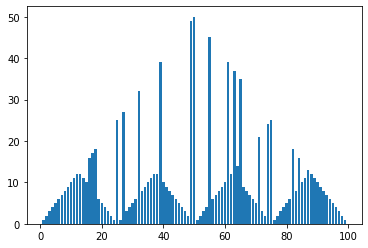

In [406]:
v_s=np.zeros(shape=(101))
v_s[0]=0.0
v_s[-1]=1.0
pi=np.zeros((101),dtype=int)
value_iteration(v_s,pi,ph=0.4,gamma=1,theta=1e-20)
plt.bar(range(1,100),pi[1:100])

<BarContainer object of 99 artists>

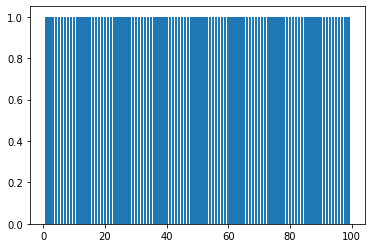

In [402]:
v_s=np.zeros(shape=(101))
v_s[0]=0.0
v_s[-1]=1.0
pi=np.zeros((101),dtype=int)
value_iteration(v_s,pi,ph=0.55,gamma=1,theta=1e-20)
plt.bar(range(1,100),pi[1:100])

<BarContainer object of 99 artists>

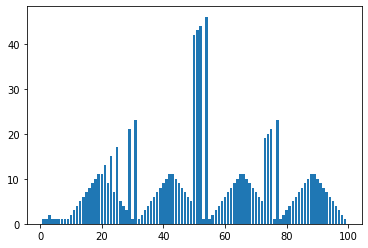

In [403]:
v_s=np.random.random(size=(101))
v_s[0]=0
v_s[-1]=1
pi=np.ones((101),dtype=int)
value_iteration(v_s,pi,ph=0.25,gamma=1,theta=1e-20)
plt.bar(range(1,100),pi[1:100])